In [29]:
from FedDifPrivModels.FedPGMDataset import FedPGMDataset
from FedDifPrivModels.FedDataset import FedDataset
from FedDifPrivModels.FedAllInOnePGM import FedAllInOnePGM
from FedDifPrivModels.FedAdapIterPGM import FedAdapIterPGM
from FedDifPrivModels.Evaluation import Evaluation
from FedDifPrivModels.Utils import FL_split_data, mu_from_eps_delta, eps_from_mu_delta
from mbi import domain, Dataset
import numpy as np
import pandas as pd
import pickle as pk

In [30]:
#set seed
seed = 1234
rng = np.random.default_rng(seed)

In [31]:
#get adult dataset
adult_raw = pd.concat([
    pd.read_csv("C:/Users/erkjrv/OneDrive - TNO/wp3-federated-synthetic-data/thesis_julian/original_data/adult/adult.csv", 
    usecols=["age","workclass","fnlwgt","education-num","marital-status", "occupation",
    "relationship","race","sex","capital-gain","capital-loss","hours-per-week",
    "native-country","income>50K"]),
    pd.read_csv("C:/Users/erkjrv/OneDrive - TNO/wp3-federated-synthetic-data/thesis_julian/original_data/adult/adult_test.csv", 
    usecols=["age","workclass","fnlwgt","education-num","marital-status", "occupation",
    "relationship","race","sex","capital-gain","capital-loss","hours-per-week",
    "native-country","income>50K"], escapechar='.')], ignore_index=True)
adult_raw  = adult_raw.iloc[rng.choice(len(adult_raw), size = 40000, replace=False),:].reset_index(drop=True)
diMapper = {" <=50K": 0, " >50K": 1}
lDataTypes = ["numerical","categorical", "numerical", "ordinal", "categorical", 
                "categorical", "categorical", "categorical", "categorical", "mixed",
                "mixed", "numerical", "categorical", "categorical"]
sYname = 'income>50K'
minInfo = adult_raw.min()
maxInfo = adult_raw.max()
diMinMaxInfo = dict()
diCatUniqueValuesInfo = dict()
for d in range(len(lDataTypes)):
    sVarName = adult_raw.columns[d]
    if (lDataTypes[d] == "numerical") or (lDataTypes[d] == "ordinal") or (lDataTypes[d] == "mixed"):
        #get minimum and maximum info
        diMinMaxInfo[sVarName] = [minInfo[sVarName], maxInfo[sVarName]]
    else:
        #get names info
        diCatUniqueValuesInfo[sVarName] = list(pd.unique(adult_raw[sVarName]))#list(set(adult_raw[sVarName].values))   
delimiterInfo = { "age": 0, "fnlwgt": 0, "capital-gain":0, "capital-loss":0, "hours-per-week":0}

In [32]:
#FedDifPrivModels works with mu-GDP. So if we have standard eps-delta-DP, we have to transform
dEps = 1.0
dDelta = 10**-6
dMu = mu_from_eps_delta(dEps, dDelta)[0] #0.6477

In [33]:
#set number of clients
iC = 5

#set fraction of number of observations for each client (list of length iC that sums to 1)
lFrac = iC * [1/iC]

#Create (potentially) heterogeneous data by splitting on a binary y variable. yFrac gives the relative weight of y=1 observations in each dataset. 
#For example, [5,3,2] means 50% of y=1 in dataset client 1, 30% in client 3, etc. Gives an argumentError if number of y =1 observations in a client 
#dataset should be larger than the size of this dataset. (Does not need to sum to 1)
yFrac = [1.0, 1.0, 1.0, 1.0, 1.0]

#set fraction training data
dTrainFrac = 0.75

#split data, get list of train and test datasets for each client 
lClientTrainDataRaw, lClientTestDataRaw = FL_split_data(adult_raw, dTrainFrac = dTrainFrac, iC = iC, lFrac = lFrac, sYname = sYname, yFrac = yFrac, rng = rng, diMapper = diMapper)

#for evaluation purposes,  get the total training and test dataset
dfTotalTrainData = pd.concat(lClientTrainDataRaw)
dfTotalTestData = pd.concat(lClientTestDataRaw)

Training of centralized model

In [34]:
#define object
fedAdapIterPGM = FedAdapIterPGM(dMu = dMu, rng = rng, iMaxDegree=3, bVerbose=True, sGraphType = "maxJTsize", dMaxJTsize = 2, sScoreType = "standard", bBinHierSplit = False)
centralModel, centralFedDataset = fedAdapIterPGM.fit([dfTotalTrainData], diMinMaxInfo = diMinMaxInfo, diCatUniqueValuesInfo = diCatUniqueValuesInfo, lDataTypes = lDataTypes)

start discritization and initial measurement
start initial estimation
Start initial model estimation
End initial model estimation
Squared Privacy Budget used: 20.0%
End iteration: 1. Squared Privacy Budget used: 20.714%. Measured marginal = ('marital-status', 'relationship', 'sex')
End iteration: 2. Squared Privacy Budget used: 21.429%. Measured marginal = ('occupation', 'sex', 'income>50K')
End iteration: 3. Squared Privacy Budget used: 22.143%. Measured marginal = ('relationship', 'income>50K')
End iteration: 4. Squared Privacy Budget used: 22.857%. Measured marginal = ('education-num', 'income>50K')
End iteration: 5. Squared Privacy Budget used: 23.571%. Measured marginal = ('age', 'income>50K')
End iteration: 6. Squared Privacy Budget used: 24.286%. Measured marginal = ('workclass', 'sex', 'income>50K')
End iteration: 7. Squared Privacy Budget used: 25.0%. Measured marginal = ('hours-per-week', 'income>50K')
End iteration: 8. Squared Privacy Budget used: 25.714%. Measured marginal 

Training of Federated model

In [35]:
#define object
fedAdapIterPGM = FedAdapIterPGM(dMu =dMu, rng = rng, iMaxDegree=3, bVerbose=True, sGraphType = "maxJTsize", dMaxJTsize = 2, sScoreType = "standard", bBinHierSplit = False)
fedModel, fedDataset = fedAdapIterPGM.fit(lClientTrainDataRaw, diMinMaxInfo = diMinMaxInfo, diCatUniqueValuesInfo = diCatUniqueValuesInfo, lDataTypes = lDataTypes)

start discritization and initial measurement
start initial estimation
Start initial model estimation
End initial model estimation
Squared Privacy Budget used: 20.0%
End iteration: 1. Squared Privacy Budget used: 20.714%. Measured marginal = ('marital-status', 'relationship')
End iteration: 2. Squared Privacy Budget used: 21.429%. Measured marginal = ('relationship', 'sex', 'income>50K')
End iteration: 3. Squared Privacy Budget used: 22.143%. Measured marginal = ('occupation', 'sex')
End iteration: 4. Squared Privacy Budget used: 22.857%. Measured marginal = ('race', 'income>50K')
End iteration: 5. Squared Privacy Budget used: 23.571%. Measured marginal = ('occupation', 'income>50K')
End iteration: 6. Squared Privacy Budget used: 24.286%. Measured marginal = ('education-num', 'income>50K')
End iteration: 7. Squared Privacy Budget used: 25.0%. Measured marginal = ('workclass', 'income>50K')
End iteration: 8. Squared Privacy Budget used: 25.714%. Measured marginal = ('education-num', 'sex

Training of Single client model

In [36]:
#define object
fedAdapIterPGM = FedAdapIterPGM(dMu =dMu, rng = rng, iMaxDegree=3, bVerbose=True, sGraphType = "maxJTsize", dMaxJTsize = 2, sScoreType = "standard", bBinHierSplit = False)
singleModel, singleDataset = fedAdapIterPGM.fit([lClientTrainDataRaw[0]], diMinMaxInfo = diMinMaxInfo, diCatUniqueValuesInfo = diCatUniqueValuesInfo, lDataTypes = lDataTypes)

start discritization and initial measurement
start initial estimation
Start initial model estimation
End initial model estimation
Squared Privacy Budget used: 20.0%
End iteration: 1. Squared Privacy Budget used: 20.714%. Measured marginal = ('relationship', 'sex', 'income>50K')
End iteration: 2. Squared Privacy Budget used: 21.429%. Measured marginal = ('marital-status', 'income>50K')
End iteration: 3. Squared Privacy Budget used: 22.143%. Measured marginal = ('marital-status', 'sex')
End iteration: 4. Squared Privacy Budget used: 22.857%. Measured marginal = ('sex', 'income>50K')
double (squared) privacy budget for next iteration
End iteration: 5. Squared Privacy Budget used: 24.286%. Measured marginal = ('marital-status', 'sex')
double (squared) privacy budget for next iteration
End iteration: 6. Squared Privacy Budget used: 27.143%. Measured marginal = ('marital-status', 'relationship')
End iteration: 7. Squared Privacy Budget used: 30.0%. Measured marginal = ('occupation', 'sex')
E

Generating data

In [37]:
dfCentralDataset = FedDataset.transform_to_original_space(centralModel.synthetic_data(rows = 10000).df, lDataTypes, diBins = centralFedDataset.diBins, diDefaultBins = centralFedDataset.diBins, delimiterInfo = delimiterInfo, rng = rng) 
dfFederatedDataset = FedDataset.transform_to_original_space(fedModel.synthetic_data(rows = 10000).df, lDataTypes, diBins = fedDataset.diBins, diDefaultBins = fedDataset.diBins, delimiterInfo = delimiterInfo, rng = rng) 
dfSingleDataset = FedDataset.transform_to_original_space(singleModel.synthetic_data(rows = 10000).df, lDataTypes, diBins = singleDataset.diBins, diDefaultBins = singleDataset.diBins, delimiterInfo = delimiterInfo, rng = rng) 



Evaluation

In [38]:
from dython.nominal import associations

lDatasets = [dfCentralDataset, dfFederatedDataset, dfSingleDataset]
dfTransformedTrain, dfTransformedTest, lDatasetsQuant, _ = Evaluation(lDatasets, dfTotalTrainData, dfTotalTestData, lDataTypes=lDataTypes, sSynthType = "original", sEvalType = "original").quantile_discretization()


In [39]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='w'
plt.rc('axes',edgecolor='grey')
plt.rcParams.update({"axes.grid" : True, "grid.color": "whitesmoke"})
plt.rc('legend',fontsize=8)


Text(0.5, 181.44444444444443, 'Federated')

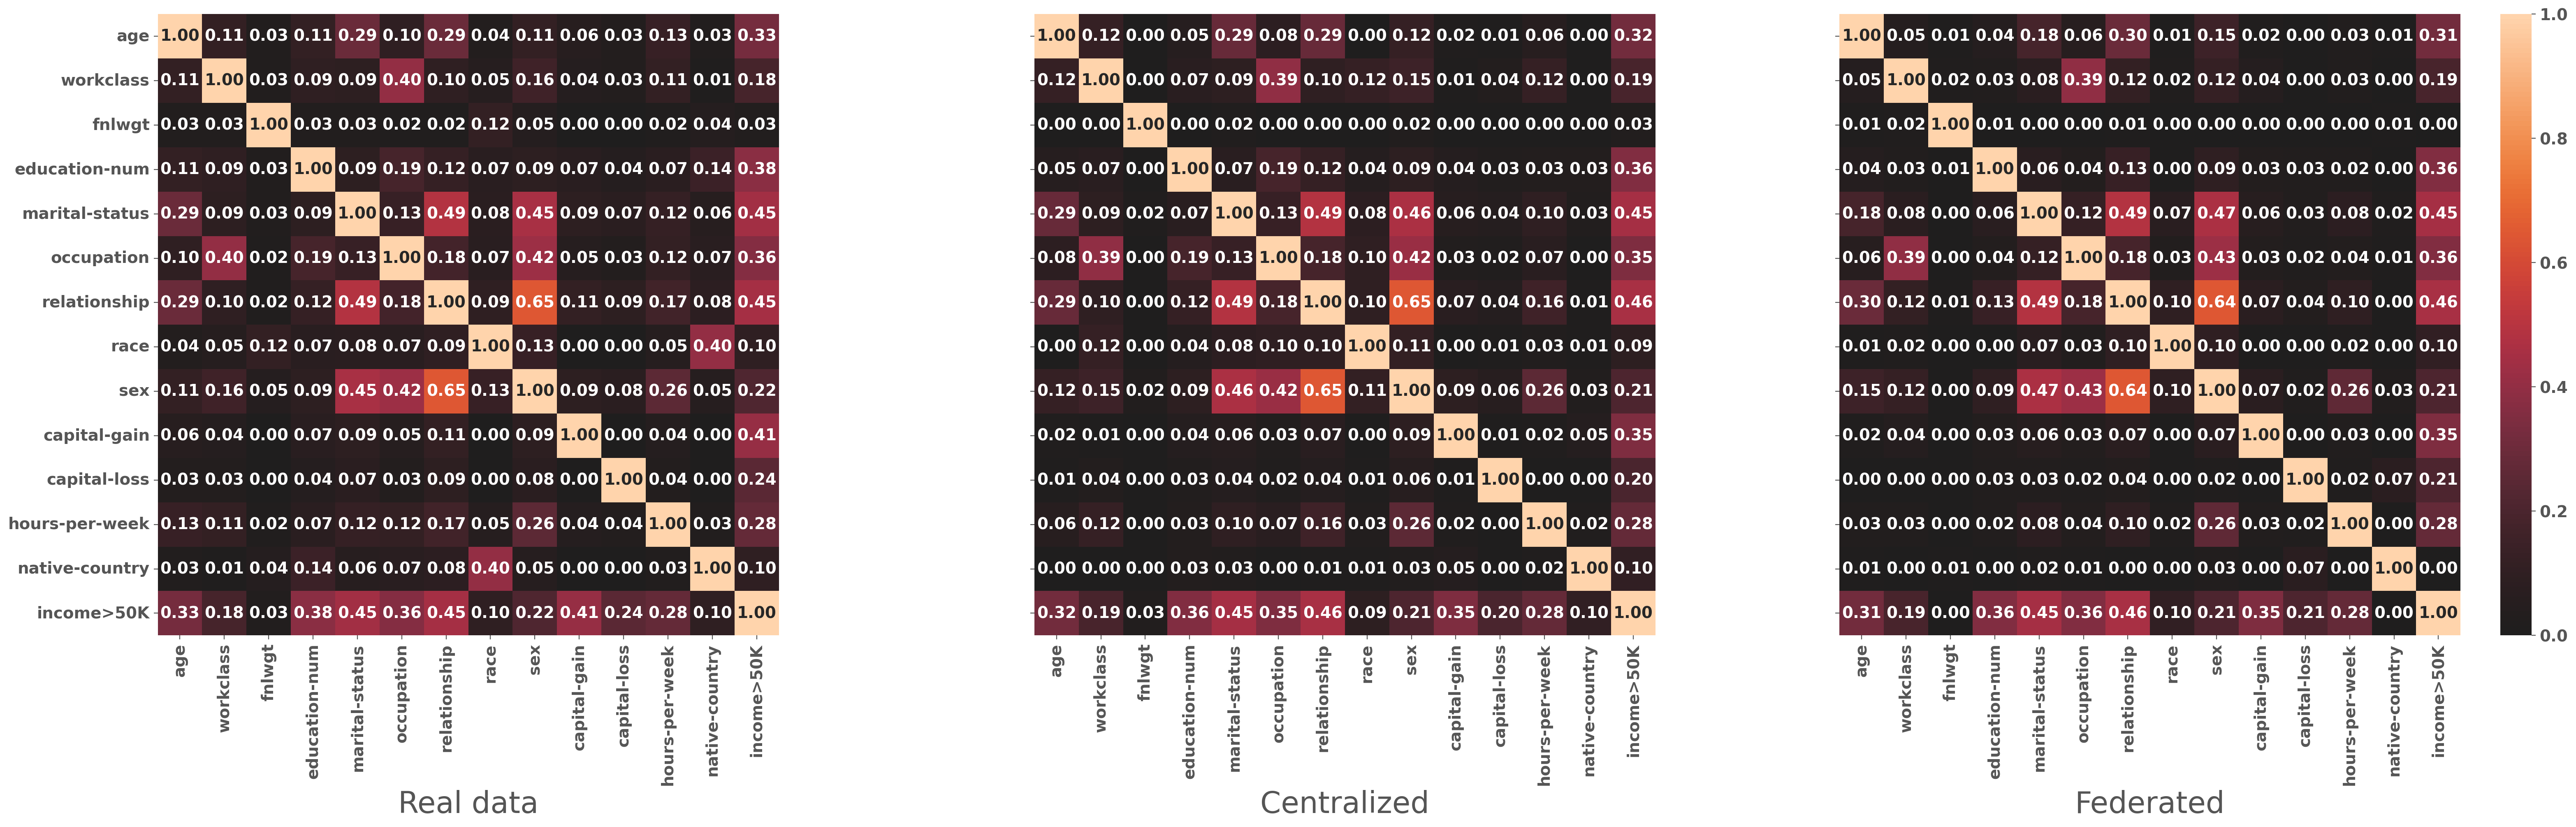

In [60]:
#subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize = (40,10), dpi = 200)

fig.subplots_adjust(hspace=0.1, wspace=0.1)
for a in axes.flatten():
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax1, ax2, ax3 = axes.flatten()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes', labelsize=28)

associations(dfTransformedTest, nominal_columns="all", nom_nom_assoc="cramer", ax = ax1, plot = False, cbar = False)
ax1.set_xlabel('Real data', fontsize = 26)
associations(lDatasetsQuant[0], nominal_columns="all", nom_nom_assoc="cramer", ax = ax2,  plot = False, cbar = False)
ax2.set_xlabel('Centralized', fontsize = 26)
associations(lDatasetsQuant[1], nominal_columns="all", nom_nom_assoc="cramer",ax = ax3,  plot = False, cbar = True)
ax3.set_xlabel('Federated', fontsize = 26)
##associations(lDatasetsQuant[2], nominal_columns="all", nom_nom_assoc="cramer",ax = ax4,  plot = False, cbar = True)
#ax4.set_xlabel('Single', fontsize = 18)

Text(0.5, 215.72222222222223, 'Single')

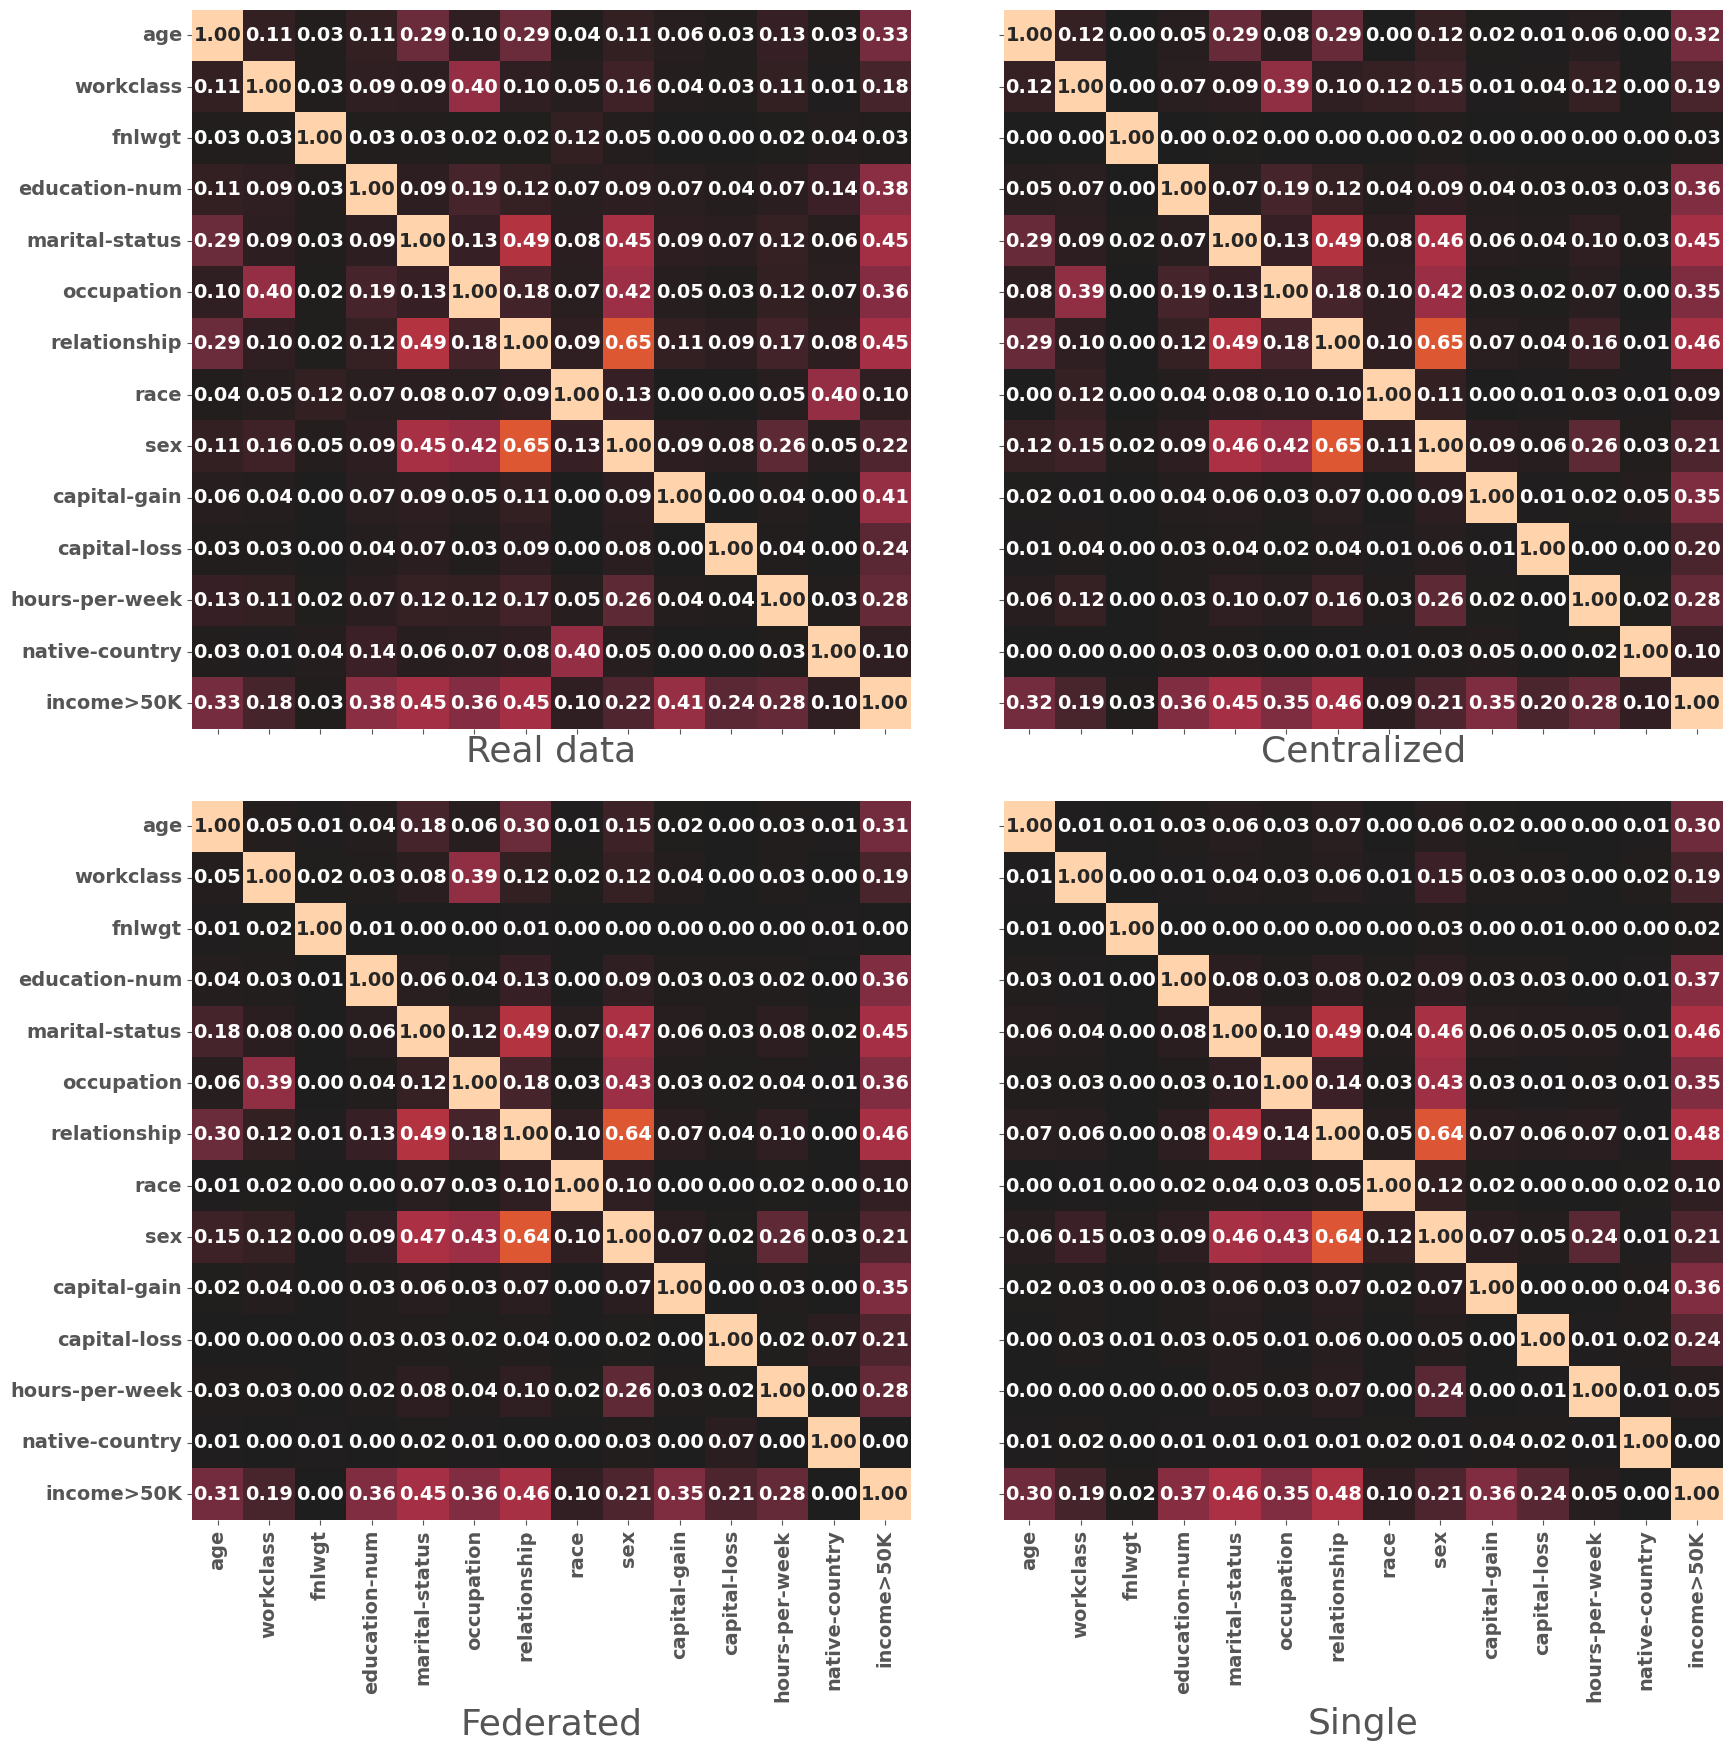

In [59]:
#subplots
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize = (20,20), dpi = 100)

fig.subplots_adjust(hspace=0.1, wspace=0.1)
for a in axes.flatten():
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax1, ax2, ax3, ax4 = axes.flatten()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes', labelsize=28)

associations(dfTransformedTest, nominal_columns="all", nom_nom_assoc="cramer", ax = ax1, plot = False, cbar = False)
ax1.set_xlabel('Real data', fontsize = 26)
associations(lDatasetsQuant[0], nominal_columns="all", nom_nom_assoc="cramer", ax = ax2,  plot = False, cbar = False)
ax2.set_xlabel('Centralized', fontsize = 26)
associations(lDatasetsQuant[1], nominal_columns="all", nom_nom_assoc="cramer",ax = ax3,  plot = False, cbar = False)
ax3.set_xlabel('Federated', fontsize = 26)
associations(lDatasetsQuant[2], nominal_columns="all", nom_nom_assoc="cramer",ax = ax4,  plot = False, cbar = False)
ax4.set_xlabel('Single', fontsize = 26)

Text(0, 0.5, 'density')

09/14/2022 11:49:31:WARNING:findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


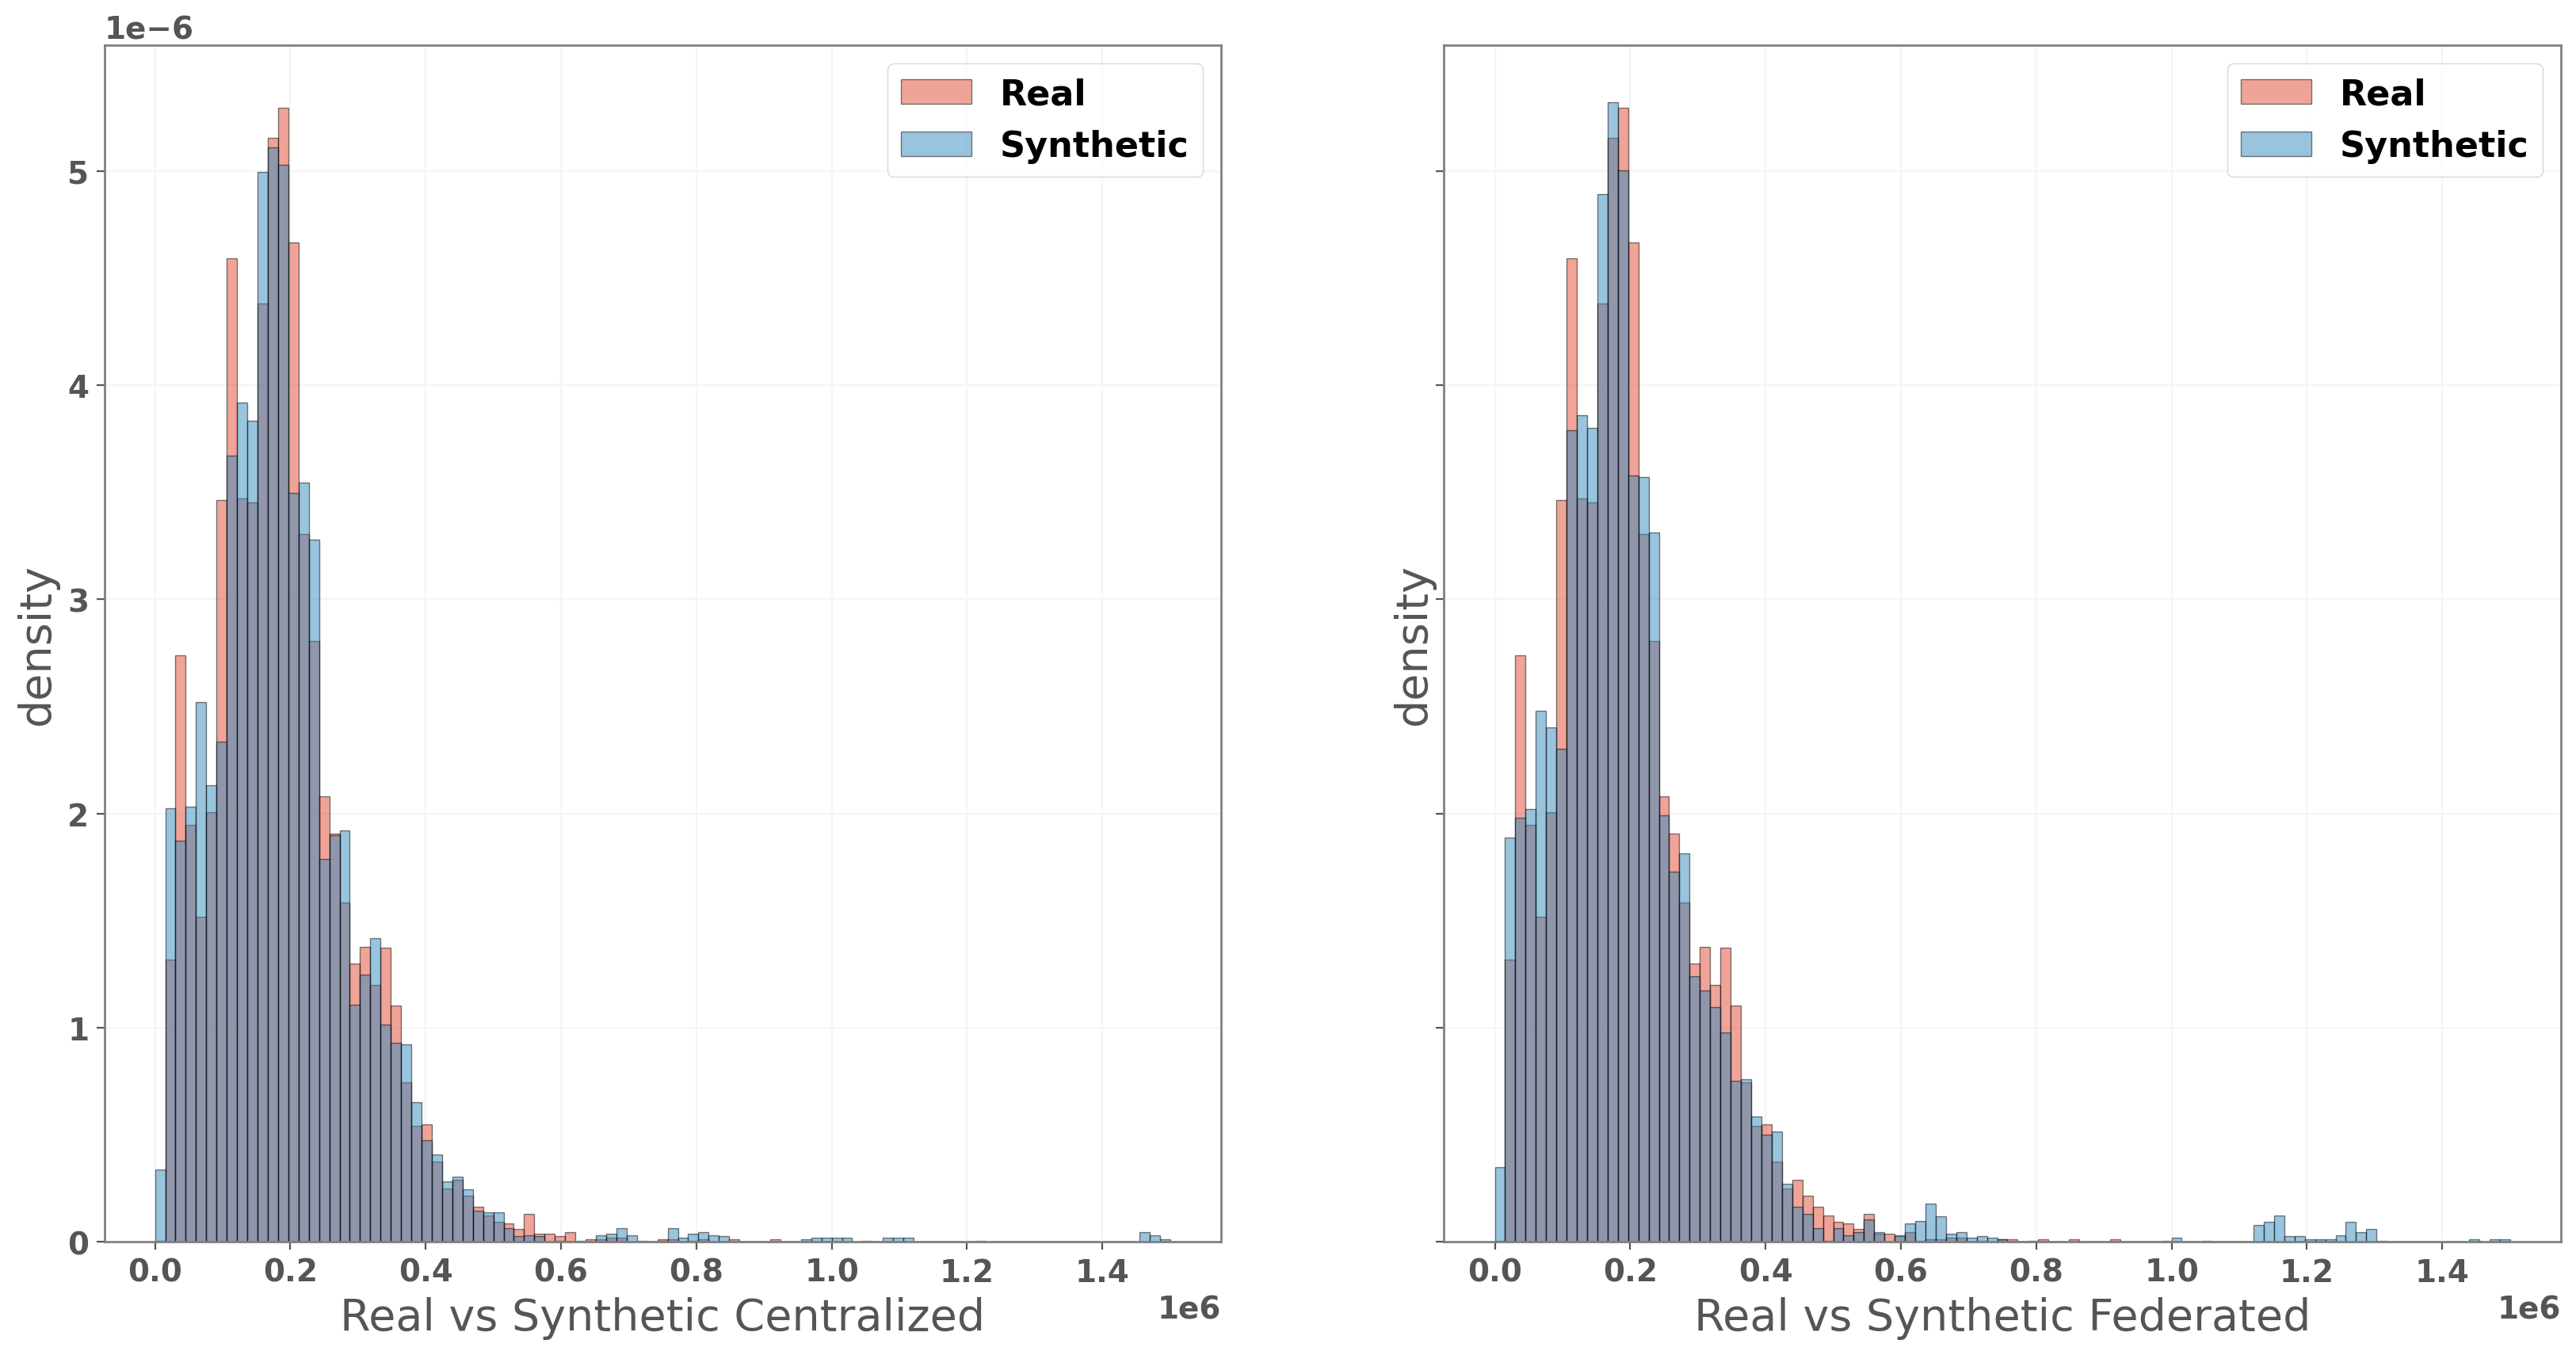

In [71]:
#variable
plt.rc('legend',fontsize=16)
plt.rc('axes', labelsize=20)
sColumn = 'fnlwgt'

#subplots
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (20,10), dpi = 200)
ax1, ax2, = axes.flatten()


#set y, bins
y = dfTotalTestData[sColumn].values
bins = np.linspace(0, 1500000, 100)

#first image
z1 = lDatasets[0][sColumn].values
ax1.hist(y, bins, alpha = 0.5, density = True, label = "Real", ec='black')
ax1.hist(z1, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
ax1.legend(loc='upper right')
ax1.set_xlabel('Real vs Synthetic Centralized')
ax1.set_ylabel("Density")

#second image
z2 = lDatasets[1][sColumn].values
ax2.hist(y, bins, alpha = 0.5, density = True, label = "Real", ec='black')
ax2.hist(z2, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
ax2.legend(loc='upper right')
ax2.set_xlabel('Real vs Synthetic Federated')
ax2.set_ylabel("Density")

#third image
#z3 = lDatasetsQuant[2][sColumn].values
#ax3.hist(y, bins, alpha = 0.5, density = True, label = "Test", ec='black')
#ax3.hist(z3, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
#ax3.legend(loc='upper right')
#ax3.set_xlabel('Synthetic Federated')
#ax3.set_ylabel("density")


Text(0, 0.5, 'Density')

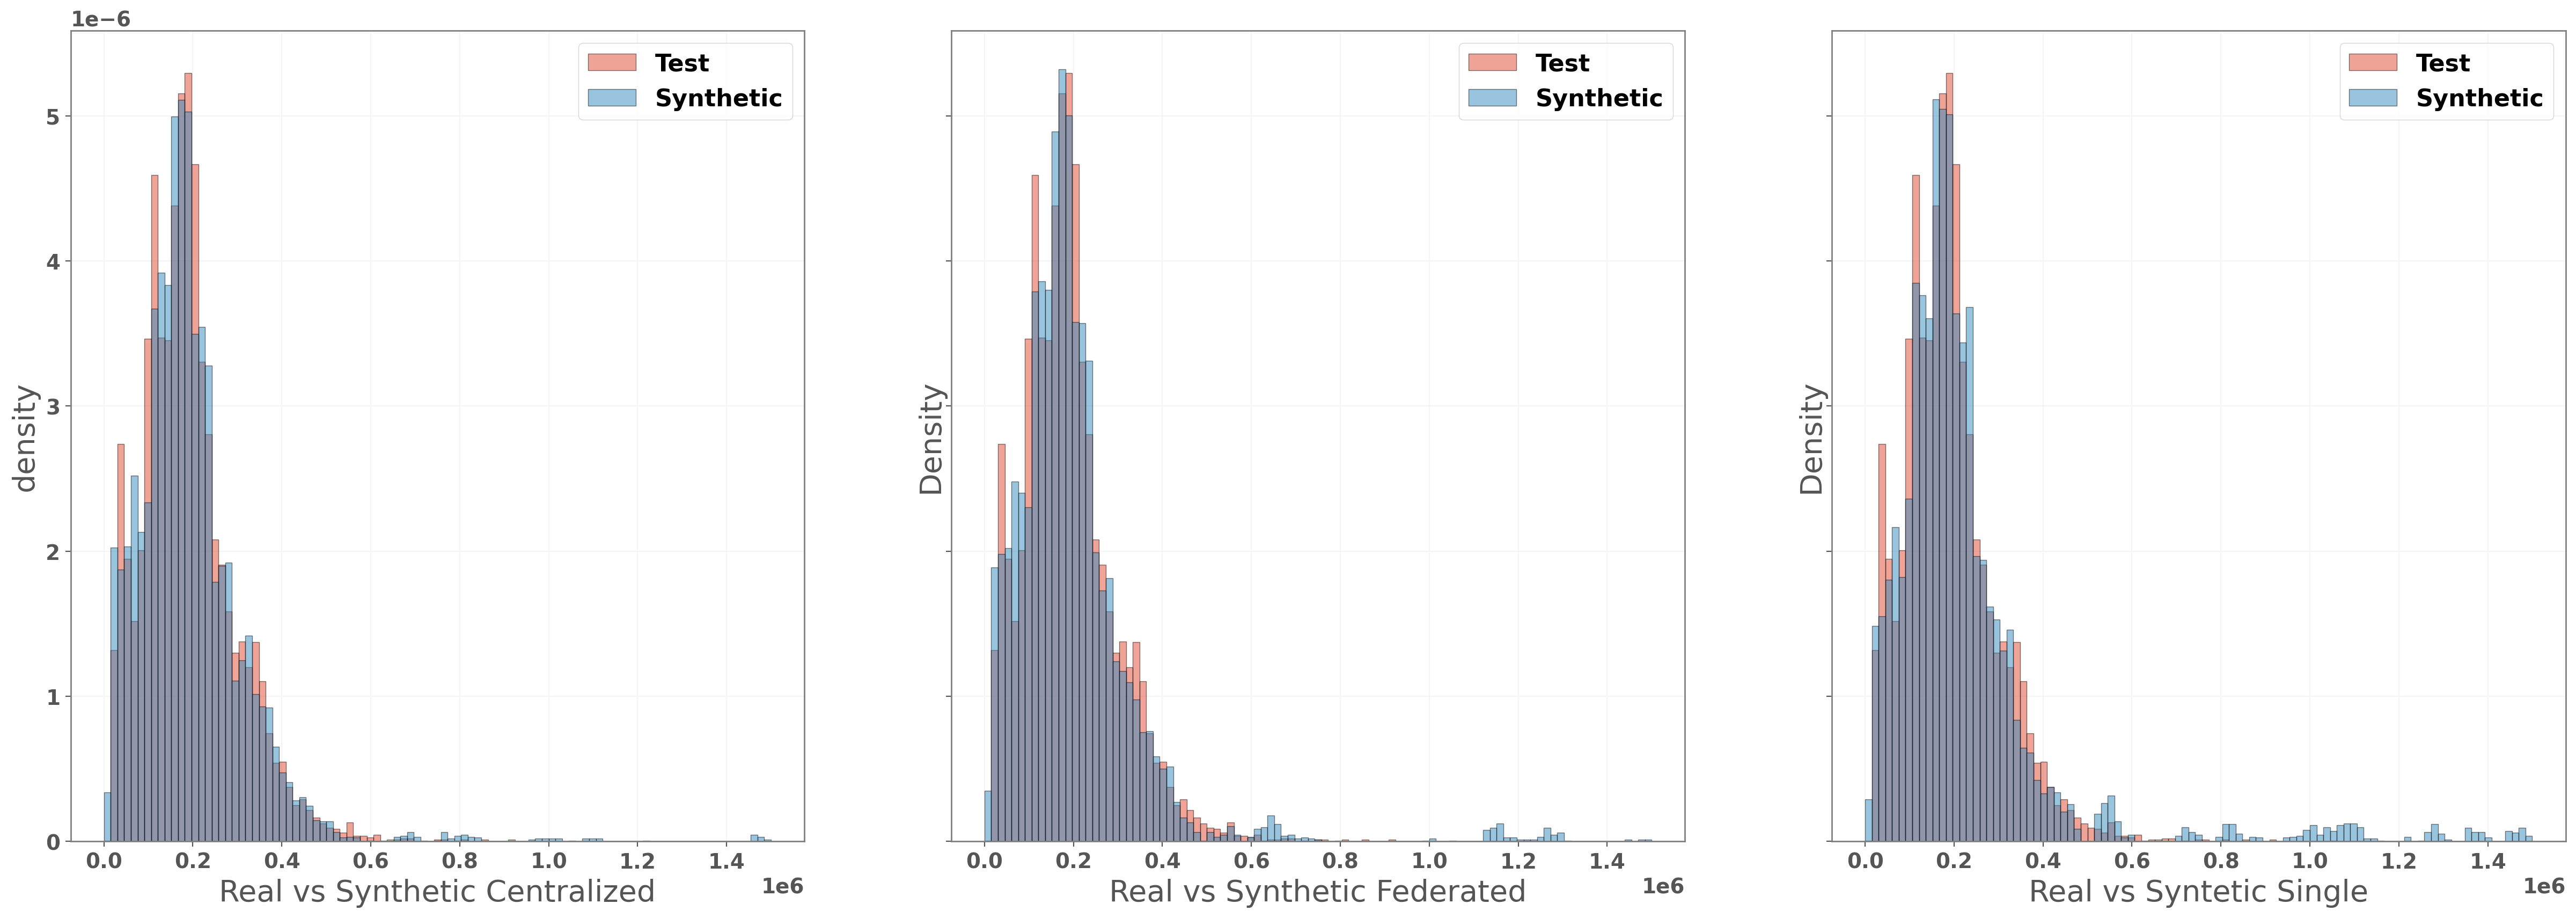

In [72]:
#variable
sColumn = 'fnlwgt'

#subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize = (30,10), dpi = 200)
ax1, ax2, ax3 = axes.flatten()


#set y, bins
y = dfTotalTestData[sColumn].values
bins = np.linspace(0, 1500000, 100)

#first image
z1 = lDatasets[0][sColumn].values
ax1.hist(y, bins, alpha = 0.5, density = True, label = "Test", ec='black')
ax1.hist(z1, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
ax1.legend(loc='upper right')
ax1.set_xlabel('Real vs Synthetic Centralized')
ax1.set_ylabel("density")

#second image
z2 = lDatasets[1][sColumn].values
ax2.hist(y, bins, alpha = 0.5, density = True, label = "Test", ec='black')
ax2.hist(z2, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
ax2.legend(loc='upper right')
ax2.set_xlabel('Real vs Synthetic Federated')
ax2.set_ylabel("Density")

#third image
z3 = lDatasets[2][sColumn].values
ax3.hist(y, bins, alpha = 0.5, density = True, label = "Test", ec='black')
ax3.hist(z3, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
ax3.legend(loc='upper right')
ax3.set_xlabel('Real vs Syntetic Single')
ax3.set_ylabel("Density")